In [1]:
options(stringsAsFactors = FALSE, repr.plot.width=16, repr.plot.height=9)
library(dplyr)
library(ggplot2)
library(tidyr)
library(caret)
library(cowplot)
library(pheatmap)

set.seed(20220327)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice



## predict the best matrix/polarity for a given molecule based on their molecular fingerprint

by Martijn Molenaar, m.r.molenaar@protonmail.com

In [2]:
## read in data 
spotting_data <- read.csv(file = '3june22_ions_no_nl_primary_adducts.csv')

fingerprints <- read.csv(file = 'fingerprints.csv')

physchem_properties <- read.csv(file = 'physchem_properties.csv')

In [3]:
colnames(fingerprints) <- gsub("^X","bit#",colnames(fingerprints))

In [4]:
physchem_properties$pka_strongest_acidic[is.na(
     physchem_properties$pka_strongest_acidic)] <- max(physchem_properties$pka_strongest_acidic, na.rm = T)


physchem_properties$pka_strongest_basic[is.na(
     physchem_properties$pka_strongest_basic)] <- min(physchem_properties$pka_strongest_basic, na.rm = T)

In [5]:
physchem_properties[,-1] <- sapply(physchem_properties[,-1], scale)
fingerprints[,-1] <- sapply(fingerprints[,-1], scale)

In [6]:
fingerprints <-  left_join(x = fingerprints  %>% rename(name_short = mol_name),
            y = physchem_properties,  by = 'name_short')

In [7]:
bit_columns <- grep("bit",colnames(fingerprints))
phys_columns <- which(colnames(fingerprints) %in% colnames(physchem_properties[,-1]))


In [8]:
colnames(spotting_data)[colnames(spotting_data) == 'Matrix.short'] <- 'matrix'
colnames(spotting_data)[colnames(spotting_data) == 'Polarity'] <- 'polarity'


In [9]:
## summarise spotting data 
## spot_sum_intensity_relative is relative performance of a molecule between the matrices.
## 0 = worst, 1 = best

spotting_data_summary <-
spotting_data %>% group_by(matrix, polarity, name_short) %>%
  summarise(spot_sum_intensity = max(spot_intensity),
            spot_sum_intensity = ifelse(spot_sum_intensity < 0,0,spot_sum_intensity),
            spot_sum_intensity = sqrt(spot_sum_intensity)   ## arbitrary transformation
            ) %>%
  ungroup() %>% 
  group_by(name_short) %>%
  mutate(spot_sum_intensity_relative = spot_sum_intensity / max(spot_sum_intensity))

`summarise()` has grouped output by 'matrix', 'polarity'. You can override
using the `.groups` argument.


In [10]:
spotting_data_summary <- spotting_data_summary[!is.nan(
                                 spotting_data_summary$spot_sum_intensity_relative),]

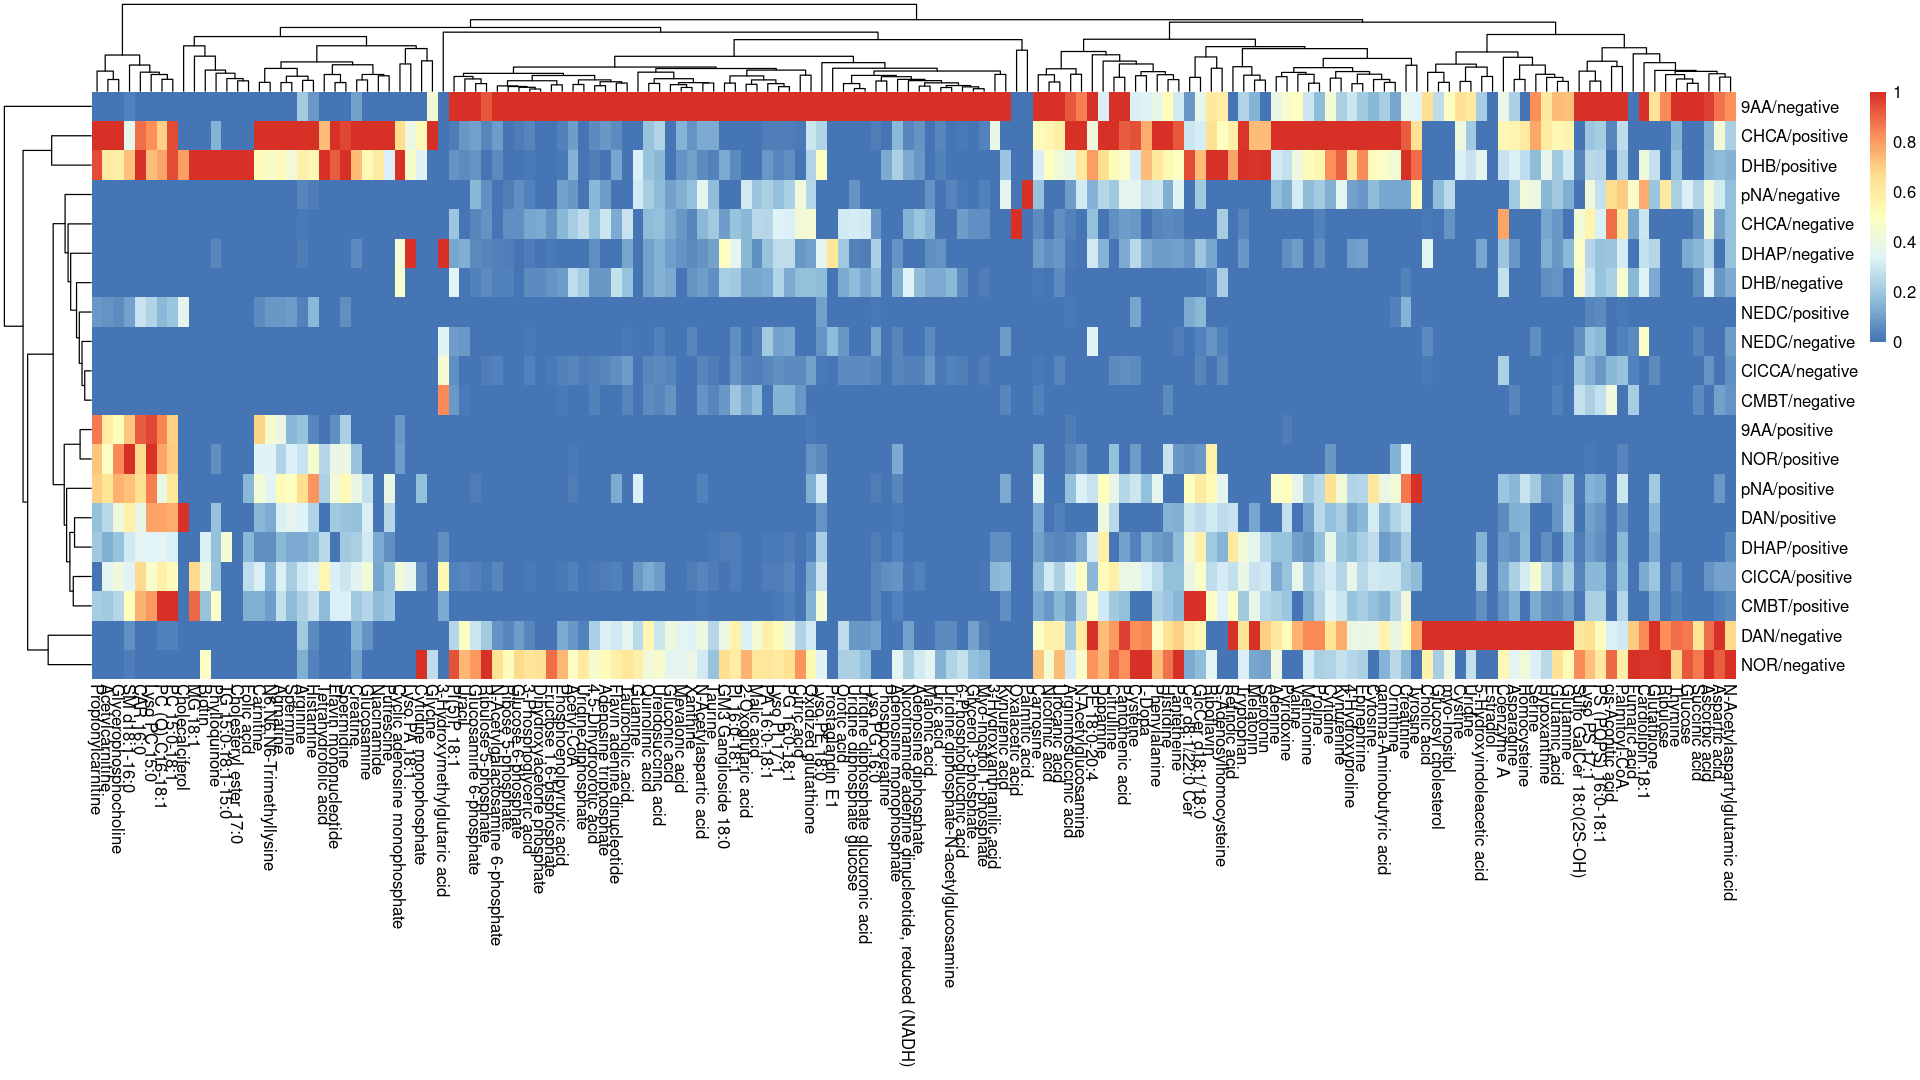

In [11]:
## generate heatmap for viz

spotting_data_summary_mat <-
spotting_data_summary %>% mutate(mat_pol = paste0(matrix,"/",polarity)) %>%
  select(mat_pol, name_short, spot_sum_intensity_relative) %>%
  pivot_wider(names_from = name_short, values_from = spot_sum_intensity_relative) %>% data.frame
  #spread(key = name_short, value = spot_sum_intensity_relative, convert = F) %>% data.frame

colnames(spotting_data_summary_mat)[-1] <- unique(spotting_data_summary$name_short)
rownames(spotting_data_summary_mat) <- spotting_data_summary_mat$mat_pol
spotting_data_summary_mat$mat_pol <- NULL

heatmap_a <- pheatmap(spotting_data_summary_mat)

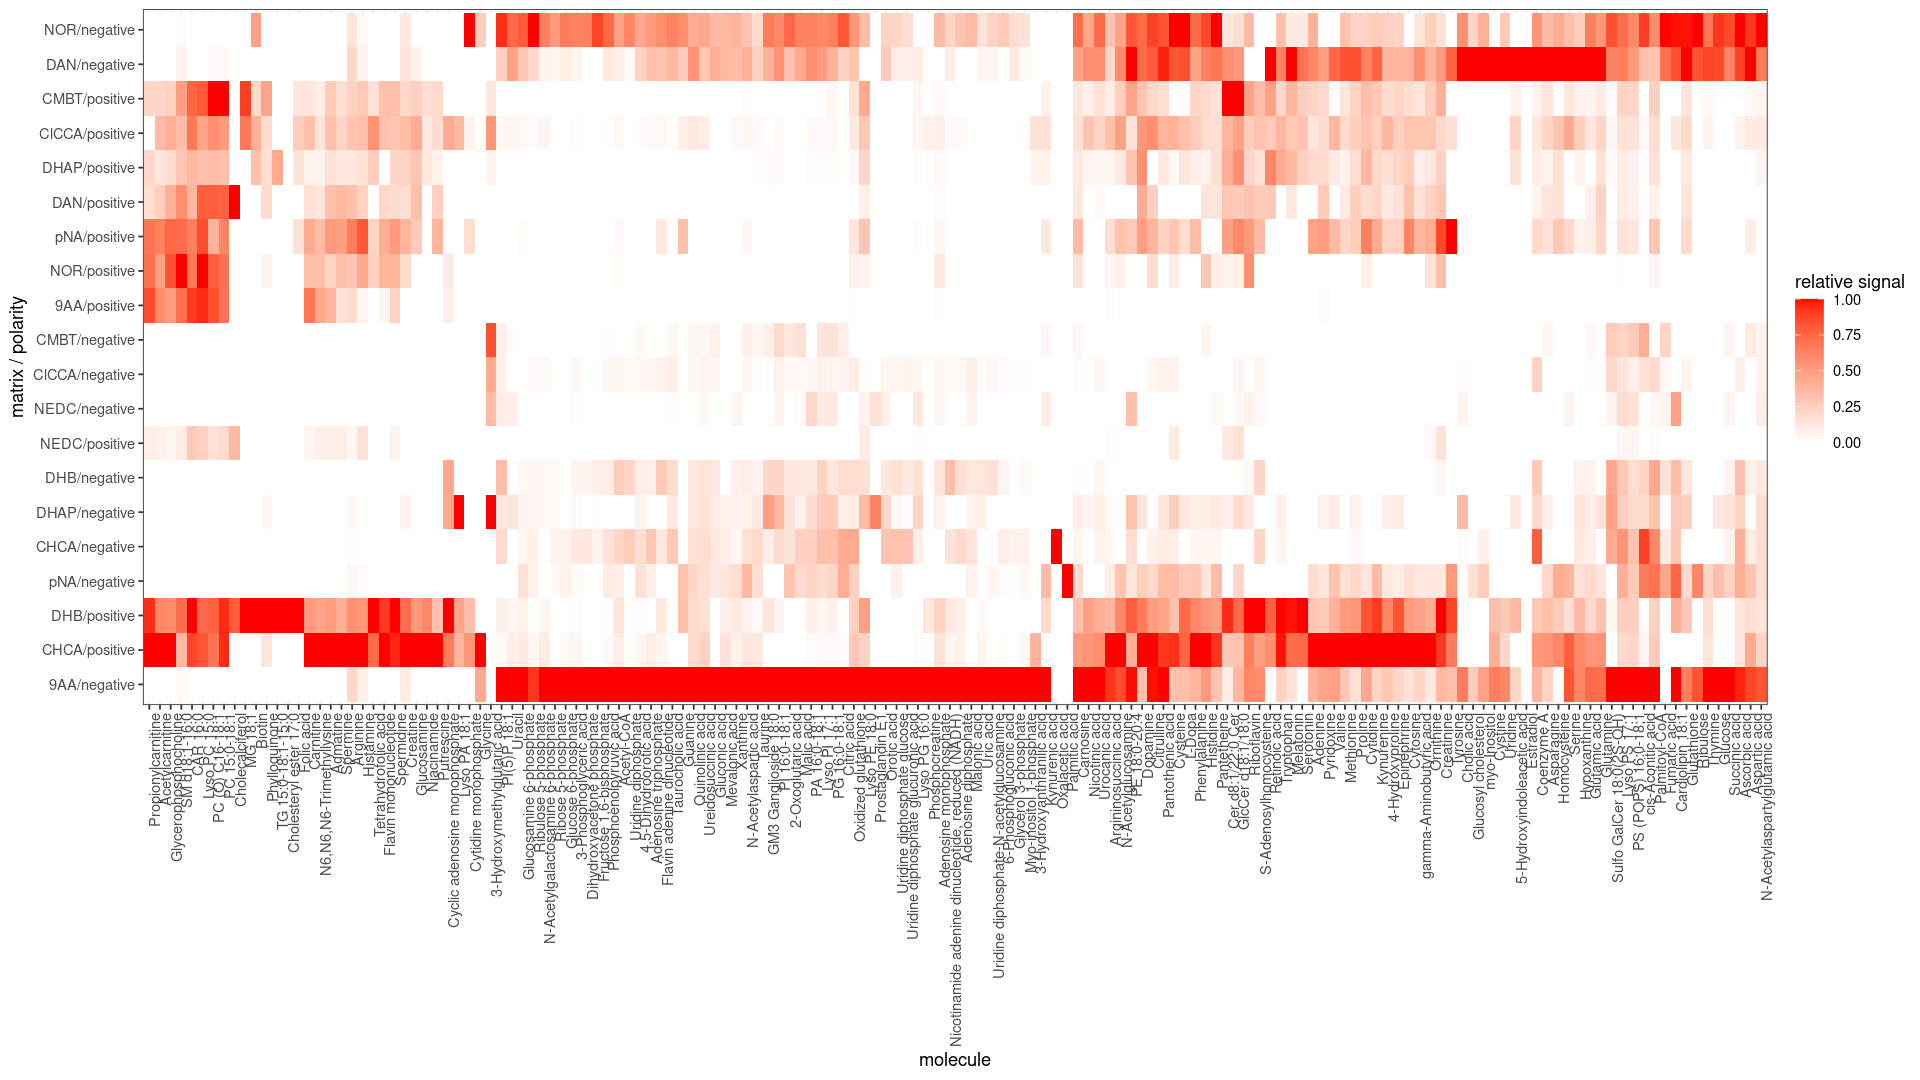

In [12]:
## now in ggplot style

## keep order of the prev heatmap
spotting_data_summary$mat_pol <- factor(paste0(spotting_data_summary$matrix,"/",spotting_data_summary$polarity), levels = heatmap_a$tree_row$labels[heatmap_a$tree_row$order])
spotting_data_summary$name_short <- factor(spotting_data_summary$name_short, levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])

ggplot(data = spotting_data_summary, 
       aes(x = name_short, 
           y = mat_pol, 
           fill = spot_sum_intensity_relative))+
  #geom_bar(stat = "identity")+
  geom_tile()+
  scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
  labs(fill = "relative signal", x = "molecule", y = "matrix / polarity")+
  theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [13]:
## define training and validtion set
sampling <- sample(unique(spotting_data_summary$name_short))
train <- sampling[1:round(length(sampling) * (2 / 3))]
validate <-  sampling[(1+round(length(sampling) * (2 / 3))):length(sampling)]

### predict by fingerprint-bits

In [14]:
## translate fingerprints into PCA, add to  spotting_data_summary
## first, use only fingerprint-bits as predictors

fingerprints_matrix <- as.matrix(fingerprints[,bit_columns])

colnames(fingerprints_matrix) <- NULL
rownames(fingerprints_matrix) <-fingerprints$mol_name

fingerprints_matrix_pca <- prcomp(fingerprints_matrix, center = T, scale = T)

fingerprints_matrix_df <- data.frame(name_short = fingerprints$name_short,
                                     fingerprints_matrix_pca$x[,1:100], check.names = F)

In [15]:
spotting_data_summary_bits <- 
  left_join(x = spotting_data_summary,
            y = fingerprints_matrix_df,by = 'name_short')

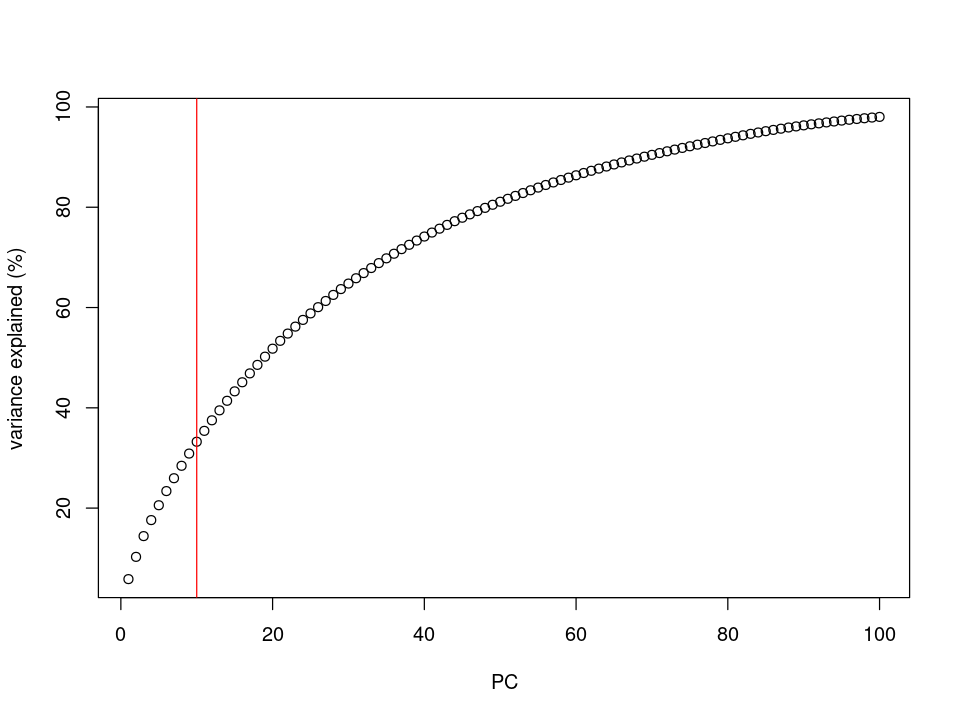

In [16]:
options(repr.plot.width=8, repr.plot.height=6)

## how many PCs to include in model?
n_PC <- 10

plot(summary(fingerprints_matrix_pca)$importance[3,1:100] * 100, xlab = "PC", ylab = "variance explained (%)")
abline(v = n_PC, col = "red")

In [17]:
### one lineair model per matrix/polarity

lm_prediction_validation <-
  sapply(spotting_data_summary_bits %>% ungroup() %>% group_split(matrix, polarity), function(i) {
    
    prediction_formula <-
      as.formula(paste0(
        'spot_sum_intensity_relative ~',
        paste0('PC', 1:n_PC, collapse = " + ")
      ))
    
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- lm(data = train_i,
                formula = prediction_formula)
    
    ## output only validation
    data.frame(
      i[1, c("matrix","polarity")],
      name_short = validate_i$name_short,
      spot_sum_intensity_relative = validate_i$spot_sum_intensity_relative,
      predicted = predict(model, newdata = validate_i)
    )
    
    
  }, simplify = F) %>% bind_rows()

In [18]:
### for comparison, also one kNN regression model per matrix/polarity

knn_prediction_validation <-
  sapply(spotting_data_summary_bits %>% ungroup() %>% group_split(matrix, polarity), function(i) {
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- knnreg(y = train_i$spot_sum_intensity_relative,
                    x = train_i[,c(paste0("PC",1:n_PC))],
                    k = 5)     ### mean of 5 neighbors, is arbitrary
   
    ## output only validation
    data.frame(
       i[1, c("matrix","polarity")],
       name_short = validate_i$name_short,
       spot_sum_intensity_relative = validate_i$spot_sum_intensity_relative,
       predicted = predict(model, newdata = validate_i[,c(paste0("PC",1:n_PC))])
    )
    
    
  }, simplify = F) %>% bind_rows()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



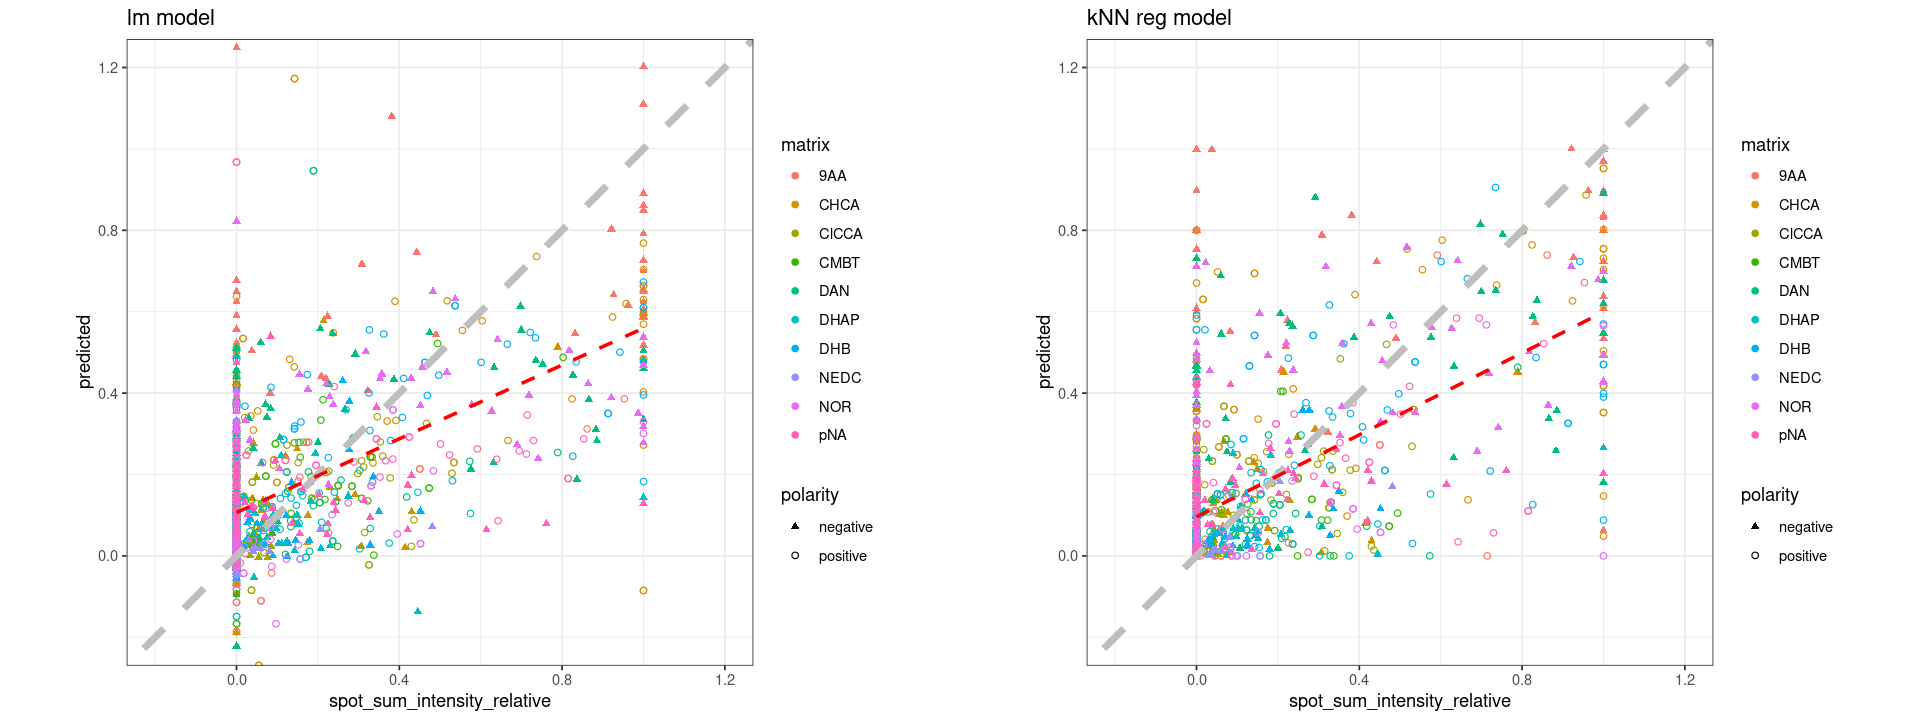

In [19]:
options(repr.plot.width=16, repr.plot.height=6)

plot_grid(
ggplot(data = lm_prediction_validation, 
       aes(x = spot_sum_intensity_relative, y = predicted, shape = polarity, color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed(xlim = c(-.2,1.2), ylim = c(-.2,1.2))+
  labs(title = "lm model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)),
ggplot(data = knn_prediction_validation, 
       aes(x = spot_sum_intensity_relative, y = predicted, shape = polarity, color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed(xlim = c(-.2,1.2), ylim = c(-.2,1.2))+
  labs(title = "kNN reg model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)))

In [20]:
## lm model performance:

## overall
lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) 

## per polarity / matrix
lm_prediction_validation %>% group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) %>%
  arrange(desc(r))



r
<dbl>
0.5623185


`summarise()` has grouped output by 'polarity'. You can override using the
`.groups` argument.


polarity,matrix,r
<chr>,<chr>,<dbl>
positive,9AA,0.646784370
negative,ClCCA,0.596774497
negative,DHB,0.595546153
negative,CHCA,0.529149628
positive,NOR,0.485597245
positive,DHB,0.468764408
negative,9AA,0.425114421
positive,CMBT,0.398470636
positive,DHAP,0.297683351


In [21]:
## kNN reg model performance:

## overall
knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) 

## per polarity / matrix
knn_prediction_validation %>% group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) %>%
  arrange(desc(r))



r
<dbl>
0.6173669


`summarise()` has grouped output by 'polarity'. You can override using the
`.groups` argument.


polarity,matrix,r
<chr>,<chr>,<dbl>
positive,9AA,0.8372778
positive,NOR,0.6313582
negative,DHB,0.5754187
negative,ClCCA,0.5526946
negative,NEDC,0.5405899
negative,CHCA,0.5398245
positive,NEDC,0.5141334
negative,CMBT,0.4782204
negative,NOR,0.4340091


In [22]:
# show orignal data and predictions in heatmaps


plotsABC <- {
 AB <- knn_prediction_validation %>% 
  mutate(mat_pol = factor(paste0(matrix,"/",polarity), levels = levels(spotting_data_summary$mat_pol)),
         name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
  A <- ggplot(data = ., 
         aes(x = name_short, 
             y = mat_pol, 
             fill = spot_sum_intensity_relative))+
    geom_tile(show.legend = F)+
    scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix / polarity", title = "validation set")+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  B <- ggplot(data = ., 
              aes(x = name_short, 
                  y = mat_pol, 
                  fill = predicted))+
    geom_tile(show.legend = F)+
    scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix / polarity", 
         title = "kNN regression", subtitle = knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
           summarise(r = paste0("r = ",format(cor(predicted, spot_sum_intensity_relative), digit =3))) %>%
           pull(r) )+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  list(A,B)
         }
  
  C <-
    lm_prediction_validation %>% 
    mutate(mat_pol = factor(paste0(matrix,"/",polarity), levels = levels(spotting_data_summary$mat_pol)),
           name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
             
             C <- ggplot(data = ., 
                         aes(x = name_short, 
                             y = mat_pol, 
                             fill = predicted))+
               #geom_bar(stat = "identity")+
               geom_tile(show.legend = F)+
               scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
               labs(fill = "relative signal", x = "molecule", y = "matrix / polarity", 
                    title = "lm regression",subtitle = lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
                      summarise(r = paste0("r = ",format(cor(predicted, spot_sum_intensity_relative), digit =3))) %>%
                      pull(r))+
               theme_bw()+
               theme(axis.text.x = element_text(angle = 90, hjust = 1))
             
             C
           }
  
  list(A = AB[[1]],
       B = AB[[2]],
       C = C)
  
}


plotsABC <- plot_grid(ggdraw()+draw_label('predictors: fingerprint-bits', 
                                          fontface = "bold"),
                      plotsABC[[1]],plotsABC[[2]],plotsABC[[3]], scale = 1, hjust = -2, vjust = 1,
                      align = "v", ncol = 1, rel_heights = c(.1,1,1,1.7))+ 
            theme(plot.background = element_rect(fill = "white", colour = NA))

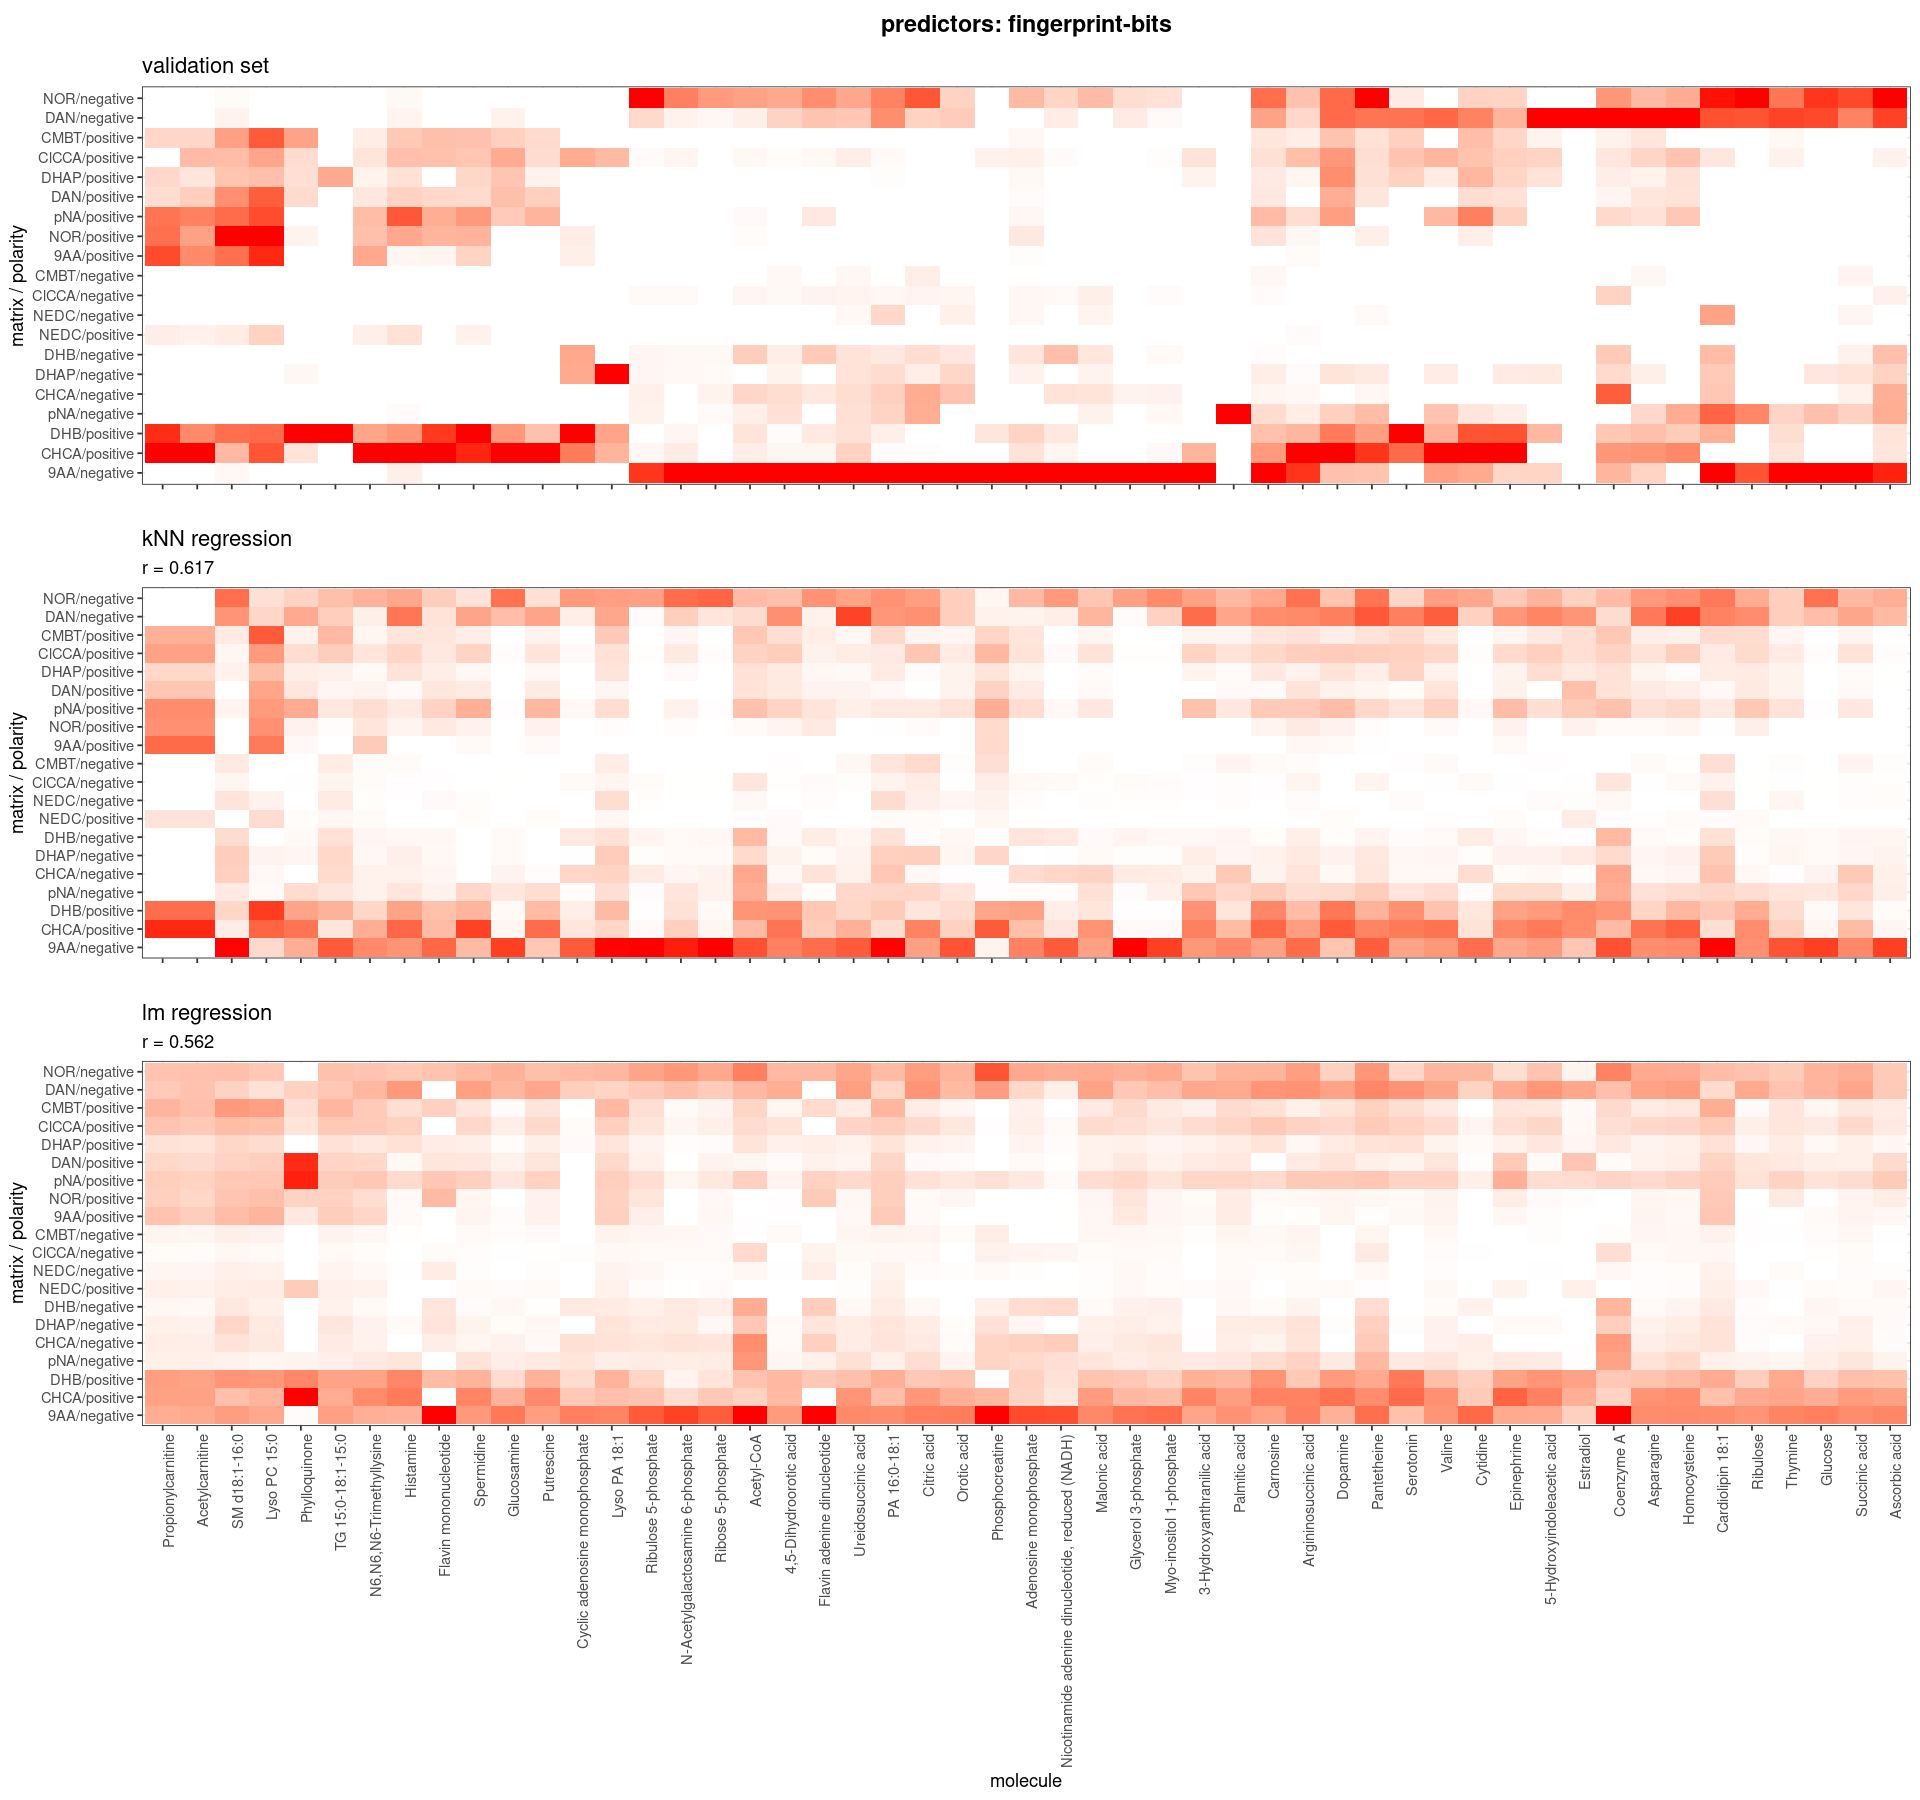

In [23]:
options(repr.plot.width=16, repr.plot.height=15)

plotsABC

In [24]:
## save plot as PNG

#save_plot(plotsABC, filename = "matrix_prediction_validation_bits.png", base_height = 12, base_width = 7)

### predict by bits and phys properties

In [25]:
## translate fingerprints into PCA, add to  spotting_data_summary
## first, use only fingerprint-bits as predictors

fingerprints_matrix <- as.matrix(fingerprints[,c(bit_columns, phys_columns)])

colnames(fingerprints_matrix) <- NULL
rownames(fingerprints_matrix) <-fingerprints$mol_name

fingerprints_matrix_pca <- prcomp(fingerprints_matrix, center = T, scale = T)

fingerprints_matrix_df <- data.frame(name_short = fingerprints$name_short,
                                     fingerprints_matrix_pca$x[,1:100], check.names = F)

In [26]:
spotting_data_summary_bits_phys <- 
  left_join(x = spotting_data_summary,
            y = fingerprints_matrix_df,by = 'name_short')

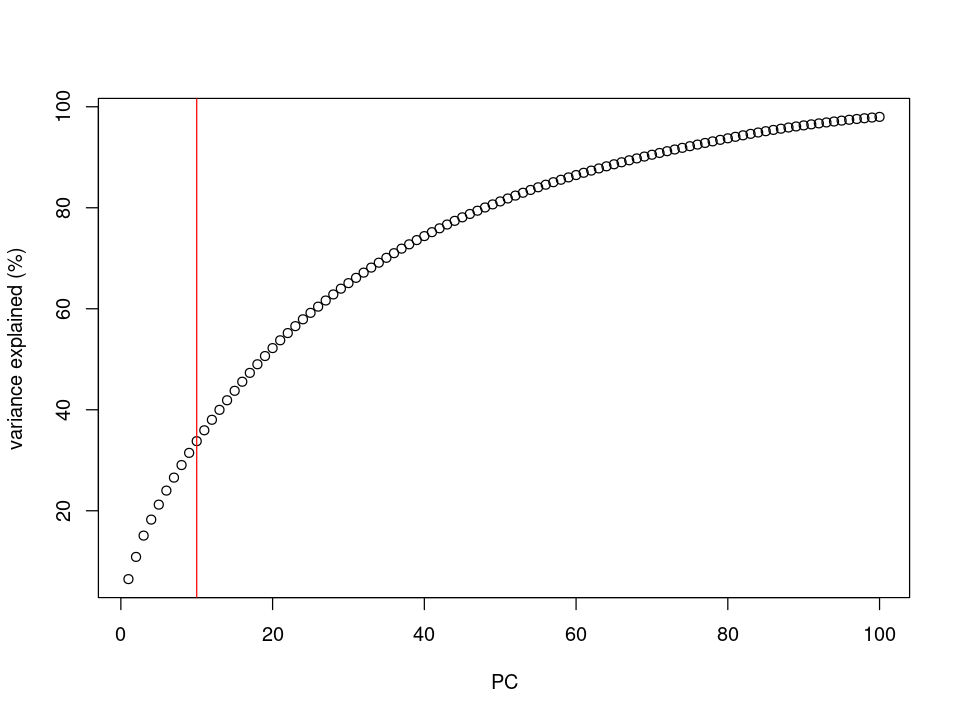

In [27]:
options(repr.plot.width=8, repr.plot.height=6)

## how many PCs to include in model?
n_PC <- 10

plot(summary(fingerprints_matrix_pca)$importance[3,1:100] * 100, xlab = "PC", ylab = "variance explained (%)")
abline(v = n_PC, col = "red")

In [28]:
### one lineair model per matrix/polarity

lm_prediction_validation <-
  sapply(spotting_data_summary_bits_phys %>% ungroup() %>% group_split(matrix, polarity), function(i) {
    
    prediction_formula <-
      as.formula(paste0(
        'spot_sum_intensity_relative ~',
        paste0('PC', 1:n_PC, collapse = " + ")
      ))
    
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- lm(data = train_i,
                formula = prediction_formula)
    
    ## output only validation
    data.frame(
      i[1, c("matrix","polarity")],
      name_short = validate_i$name_short,
      spot_sum_intensity_relative = validate_i$spot_sum_intensity_relative,
      predicted = predict(model, newdata = validate_i)
    )
    
    
  }, simplify = F) %>% bind_rows()

In [29]:
### for comparison, also one kNN regression model per matrix/polarity

knn_prediction_validation <-
  sapply(spotting_data_summary_bits_phys %>% ungroup() %>% group_split( matrix, polarity), function(i) {
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- knnreg(y = train_i$spot_sum_intensity_relative,
                    x = train_i[,c(paste0("PC",1:n_PC))],
                    k = 5)     ### mean of 5 neighbors, is arbitrary
   
    ## output only validation
    data.frame(
       i[1, c("matrix","polarity")],
       name_short = validate_i$name_short,
       spot_sum_intensity_relative = validate_i$spot_sum_intensity_relative,
       predicted = predict(model, newdata = validate_i[,c(paste0("PC",1:n_PC))])
    )
    
    
  }, simplify = F) %>% bind_rows()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



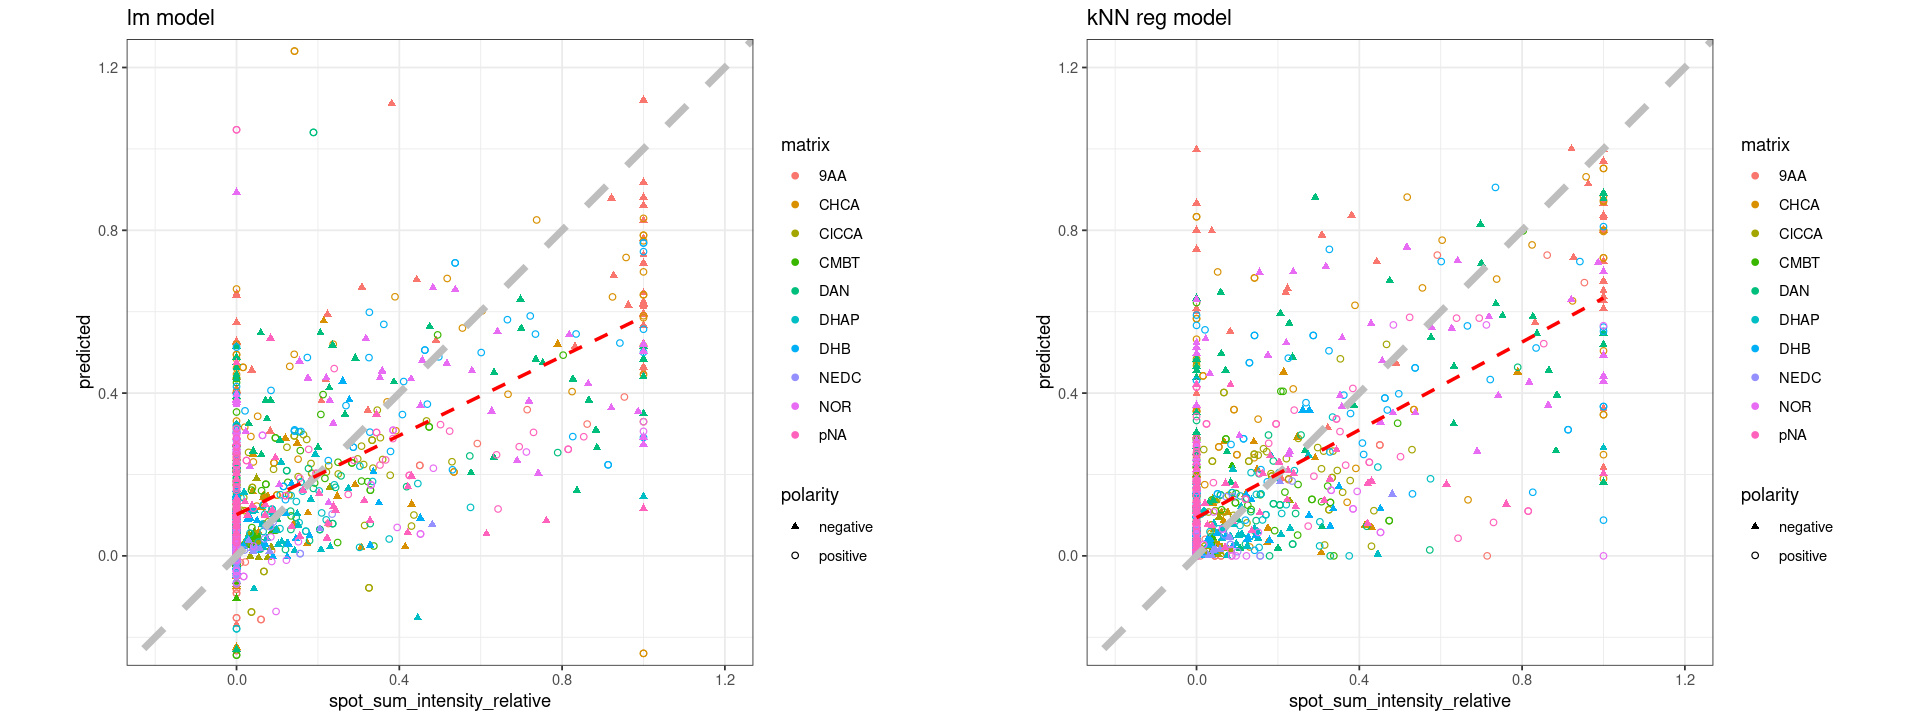

In [30]:
options(repr.plot.width=16, repr.plot.height=6)

plot_grid(
ggplot(data = lm_prediction_validation, 
       aes(x = spot_sum_intensity_relative, y = predicted, shape = polarity, color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed(xlim = c(-.2,1.2), ylim = c(-.2,1.2))+
  labs(title = "lm model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)),
ggplot(data = knn_prediction_validation, 
       aes(x = spot_sum_intensity_relative, y = predicted, shape = polarity, color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed(xlim = c(-.2,1.2), ylim = c(-.2,1.2))+
  labs(title = "kNN reg model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)))

In [31]:
## lm model performance:

## overall
lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) 

## per polarity / matrix
lm_prediction_validation %>% group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) %>%
  arrange(desc(r))



r
<dbl>
0.5719004


`summarise()` has grouped output by 'polarity'. You can override using the
`.groups` argument.


polarity,matrix,r
<chr>,<chr>,<dbl>
positive,9AA,0.61477722
negative,DHB,0.60886086
negative,ClCCA,0.59779164
negative,CHCA,0.53730586
positive,DHB,0.52085555
positive,NOR,0.49596485
positive,CMBT,0.49085493
negative,9AA,0.46309052
positive,DHAP,0.39667328


In [32]:
## kNN reg model performance:

## overall
knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) 

## per polarity / matrix
knn_prediction_validation %>% group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, spot_sum_intensity_relative)) %>%
  arrange(desc(r))



r
<dbl>
0.657836


`summarise()` has grouped output by 'polarity'. You can override using the
`.groups` argument.


polarity,matrix,r
<chr>,<chr>,<dbl>
positive,9AA,0.8058383
negative,DHB,0.6466545
positive,NOR,0.6133534
negative,ClCCA,0.5971845
negative,CHCA,0.5818618
negative,CMBT,0.5647977
positive,CHCA,0.5209982
negative,NEDC,0.5176281
positive,DHAP,0.5028863


In [33]:
# show orignal data and predictions in heatmaps


plotsABC <- {
 AB <- knn_prediction_validation %>% 
  mutate(mat_pol = factor(paste0(matrix,"/",polarity), levels = levels(spotting_data_summary$mat_pol)),
         name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
  A <- ggplot(data = ., 
         aes(x = name_short, 
             y = mat_pol, 
             fill = spot_sum_intensity_relative))+
    geom_tile(show.legend = F)+
    scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix / polarity", title = "validation set")+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  B <- ggplot(data = ., 
              aes(x = name_short, 
                  y = mat_pol, 
                  fill = predicted))+
    geom_tile(show.legend = F)+
    scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix / polarity", 
         title = "kNN regression", subtitle = knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
           summarise(r = paste0("r = ",format(cor(predicted, spot_sum_intensity_relative), digit =3))) %>%
           pull(r) )+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  list(A,B)
         }
  
  C <-
    lm_prediction_validation %>% 
    mutate(mat_pol = factor(paste0(matrix,"/",polarity), levels = levels(spotting_data_summary$mat_pol)),
           name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
             
             C <- ggplot(data = ., 
                         aes(x = name_short, 
                             y = mat_pol, 
                             fill = predicted))+
               #geom_bar(stat = "identity")+
               geom_tile(show.legend = F)+
               scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
               labs(fill = "relative signal", x = "molecule", y = "matrix / polarity", 
                    title = "lm regression",subtitle = lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
                      summarise(r = paste0("r = ",format(cor(predicted, spot_sum_intensity_relative), digit =3))) %>%
                      pull(r))+
               theme_bw()+
               theme(axis.text.x = element_text(angle = 90, hjust = 1))
             
             C
           }
  
  list(A = AB[[1]],
       B = AB[[2]],
       C = C)
  
}

plotsABC <- plot_grid(ggdraw()+draw_label('predictors fingerprint-bits and physical properties', 
                                          fontface = "bold"),
                      plotsABC[[1]],plotsABC[[2]],plotsABC[[3]], scale = 1, hjust = -2, vjust = 1,
                      align = "v", ncol = 1, rel_heights = c(.1,1,1,1.7))+ 
            theme(plot.background = element_rect(fill = "white", colour = NA))



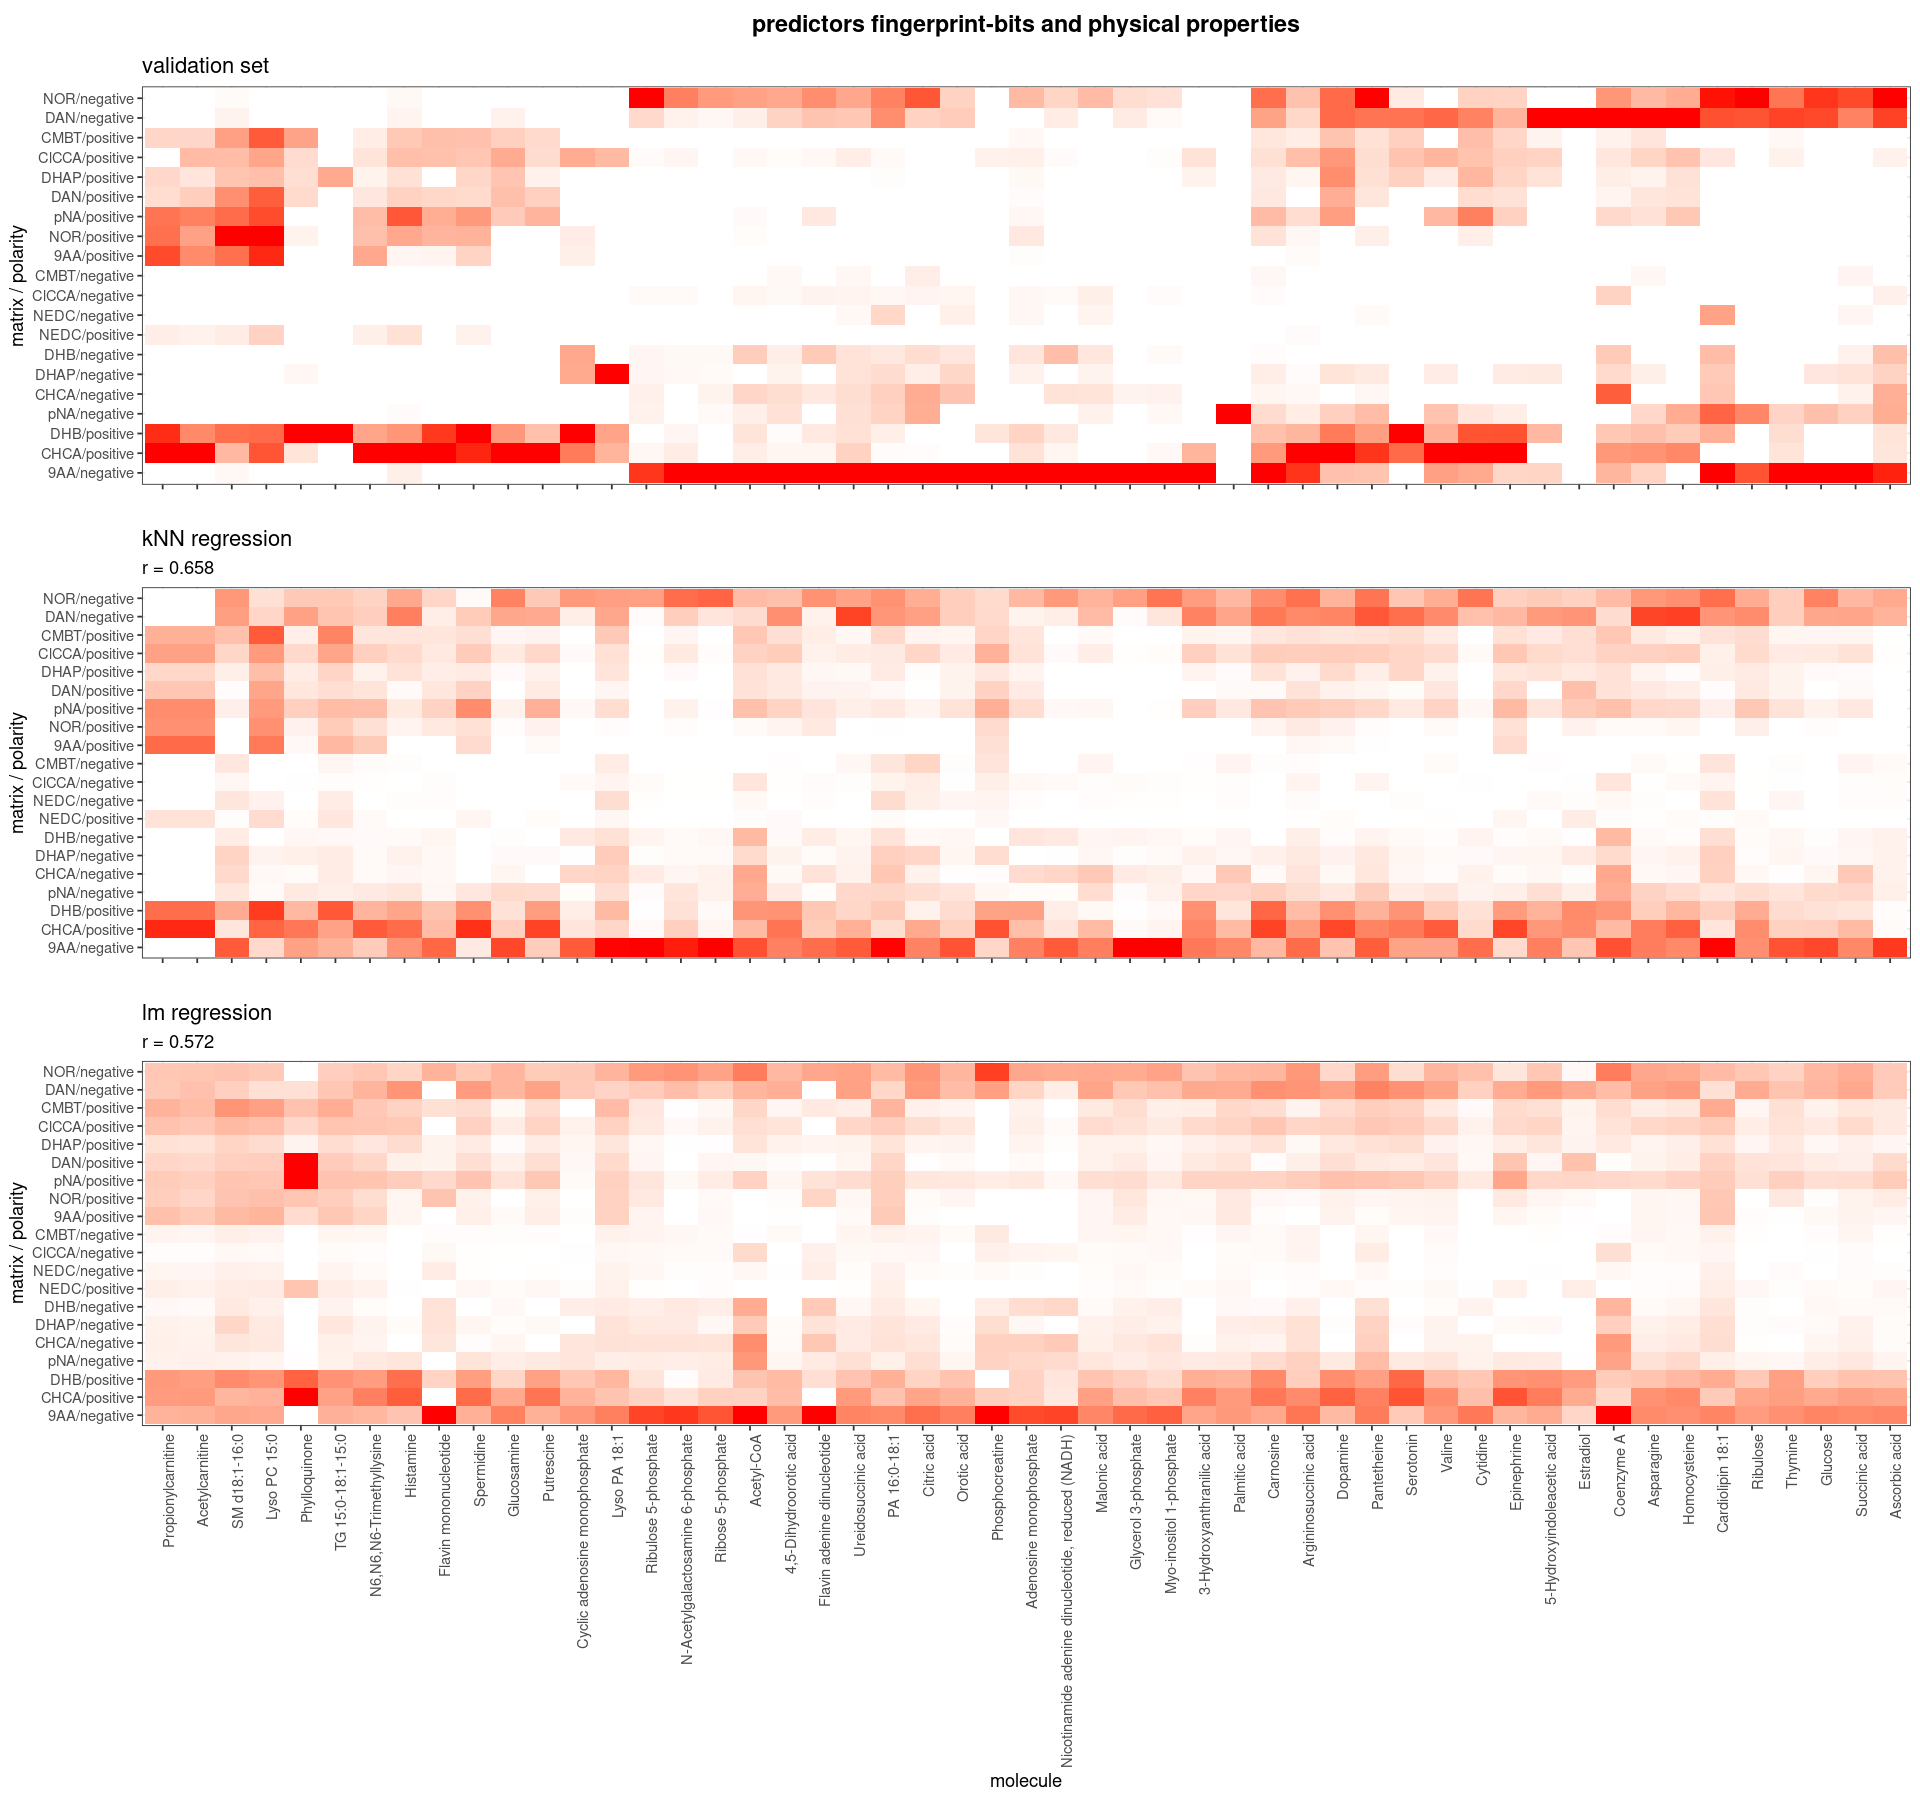

In [34]:
options(repr.plot.width=16, repr.plot.height=15)

plotsABC

In [35]:
## save plot as PNG

#save_plot(plotsABC, filename = "matrix_prediction_validation_bits_phys.png", base_height = 12, base_width = 7)

## predict unknown molecule with kNNreg model

In [36]:
## input fingerprints

finger_prints <- data.frame(unknown1 = as.integer(sample(c(0,1), size = 365, replace = T)),
                            unknown2 = as.integer(sample(c(0,1), size = 365, replace = T)))

t(finger_prints)

unknown1,1,1,1,1,1,1,1,0,1,0,⋯,1,0,1,0,1,0,1,0,1,1
unknown2,0,0,1,1,0,0,0,1,0,1,⋯,1,0,1,1,0,0,1,1,0,0


In [37]:
### translate into PCA with the earlier model

pca_s <- predict(fingerprints_matrix_pca, newdata = t(finger_prints))
pca_s

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC188,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197
unknown1,-3.014068,-3.307076,0.2457229,-0.8559181,-0.4015969,-0.4183433,1.2622751,2.210087,-1.3926759,-0.7722065,⋯,-0.2202435,-0.4400625,-0.05845997,-0.6755302,1.0129762,-0.6123194,-0.5210640,-0.2668010,-1.1950011310,0.3739592
unknown2,-2.590358,-3.652471,-0.2431849,-1.4571910,-1.5918719,0.5737644,0.9447799,1.915907,-0.2795925,-0.7946155,⋯,-0.5200797,-0.1324535,-0.66399875,-0.7651346,0.4936563,-0.7086165,0.6445245,-0.3857658,0.0002743652,0.8484117


In [38]:
## use knn reg models and predict unknowns

knn_prediction <-
  sapply(spotting_data_summary_bits_phys %>% ungroup() %>% group_split(matrix, polarity), function(i) {
    train_i <- i   ## use all here
    
    model <- knnreg(y = train_i$spot_sum_intensity_relative,
                    x = train_i[,c(paste0("PC",1:n_PC))],k =5)
    
    data.frame(
      i[1, c("matrix","polarity")],
      name_short = rownames(pca_s),
      predicted = predict(model, newdata = as_tibble(pca_s)[,1:n_PC])
    )
    
    
  }, simplify = F) %>% bind_rows()

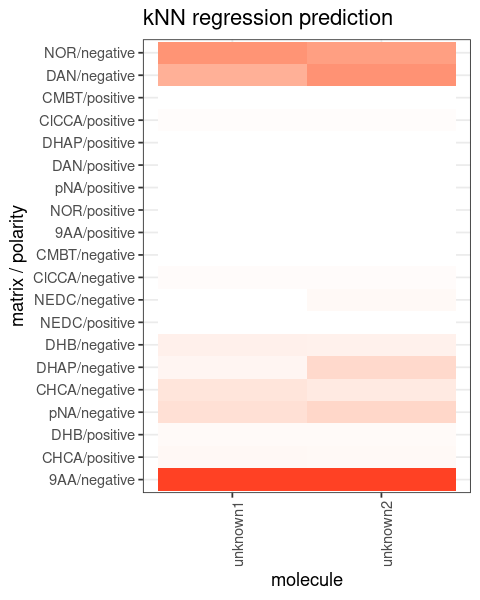

In [39]:
options(repr.plot.width=4, repr.plot.height=5)

knn_prediction %>% 
  mutate(mat_pol = factor(paste0(matrix,"/",polarity), levels = levels(spotting_data_summary_bits_phys$mat_pol))) %>% {
           
           ggplot(data = ., 
                       aes(x = name_short, 
                           y = mat_pol, 
                           fill = predicted))+
             geom_tile(show.legend = F)+
             scale_fill_gradient(low = "white", high = "red", na.value = "gray", 
                                   limits = c(0,1),
                                  oob = scales::squish)+
             labs(fill = "relative signal", x = "molecule", y = "matrix / polarity", 
                  title = "kNN regression prediction")+
             theme_bw()+
             theme(axis.text.x = element_text(angle = 90, hjust = 1))
           
  }



## which bits are predictive?

In [40]:
## generate models again, now use all data to train

lm_prediction_models <-
  sapply(spotting_data_summary_bits_phys %>% ungroup() %>% group_split(matrix, polarity), function(i) {
    
    prediction_formula <-
      as.formula(paste0(
        'spot_sum_intensity_relative ~',
        paste0('PC', 1:n_PC, collapse = " + ")
      ))
    
    train_i <- i   ## use all
    
    
    list(model = lm(data = train_i,
                    formula = prediction_formula),
         mat_pol = train_i$mat_pol[1])
    
}, simplify = F)

names(lm_prediction_models) <- sapply(lm_prediction_models, function(i){i$mat_pol})

In [41]:
## translate the coefficients of the PCs into the bits
## please double-check whether this is correct...

bit_coefficients <-
sapply(lm_prediction_models, function(mat_pol_model) {
  rowSums(t(
    t(fingerprints_matrix_pca$rotation[, 1:n_PC]) *
      mat_pol_model$model$coefficients[-1]
  ))
}, simplify = T)

rownames(bit_coefficients) <- 1:dim(bit_coefficients)[1]

bit_coefficients[1:10,1:10]

,9AA/negative,9AA/positive,CHCA/negative,CHCA/positive,ClCCA/negative,ClCCA/positive,CMBT/negative,CMBT/positive,DAN/negative,DAN/positive
1,-0.0040228829,0.0023220036,1.897002e-03,-0.0007224387,7.594266e-04,1.570937e-03,1.688332e-04,4.109696e-03,-0.0026406770,2.937822e-03
2,-0.0011058297,-0.0003293266,8.994883e-05,-0.0049672022,1.126111e-04,-2.184884e-03,-1.113690e-04,-2.956722e-03,0.0025678322,-2.186335e-04
3,-0.0040746460,0.0052083986,3.455028e-06,0.0010629524,-1.110911e-04,1.816548e-03,1.603509e-04,3.842708e-03,-0.0030920806,2.438612e-03
4,-0.0167982900,0.0030192330,-1.315400e-03,0.0212125974,1.163539e-04,7.454084e-03,-3.176090e-04,7.876728e-03,0.0143151856,2.612819e-03
5,0.0006963562,-0.0001987357,-9.601784e-06,0.0001888554,-4.369579e-06,-9.760707e-05,5.813602e-05,-4.597980e-04,0.0003030757,-3.154740e-04
6,-0.0013650454,-0.0008242478,5.741867e-04,0.0001440032,1.449942e-04,5.621446e-04,4.650961e-04,1.549288e-03,0.0054719275,7.469864e-04
7,-0.0020311311,-0.0001150460,-7.878827e-05,-0.0021008501,-1.968760e-05,-7.318684e-04,-1.529768e-04,-9.217706e-05,0.0003603774,8.839069e-04
8,0.0013696246,-0.0015252166,3.372870e-03,0.0007373553,1.334201e-03,9.211921e-04,4.270182e-04,1.470511e-03,0.0048073360,-1.081139e-04
9,0.0020817128,-0.0013993928,-4.740382e-04,-0.0016786556,-3.711198e-06,-9.737786e-04,-1.470417e-04,3.664616e-04,-0.0022708338,-9.899678e-05
10,0.0012852413,-0.0003903185,-4.467648e-04,-0.0016910902,-2.330761e-04,-7.992499e-04,-2.095117e-04,-1.102689e-03,-0.0016452268,-6.177794e-04


In [42]:
## into long format...

bit_coefficients_long <- bit_coefficients %>% data.frame(check.names = F) %>% mutate(bit = colnames(fingerprints)[-1]) %>% 
  pivot_longer(cols = 1:20, names_to = "mat_pol") %>%
  mutate(value = value / max(value))

bit_coefficients_long$bit <- factor(bit_coefficients_long$bit, levels = unique(bit_coefficients_long$bit))

bit_coefficients_long[1:10,]

bit,mat_pol,value
<fct>,<chr>,<dbl>
bit#1,9AA/negative,-0.189645934
bit#1,9AA/positive,0.109463428
bit#1,CHCA/negative,0.089428105
bit#1,CHCA/positive,-0.034057060
bit#1,ClCCA/negative,0.035800737
bit#1,ClCCA/positive,0.074056810
bit#1,CMBT/negative,0.007959103
bit#1,CMBT/positive,0.193738472
bit#1,DAN/negative,-0.124486264


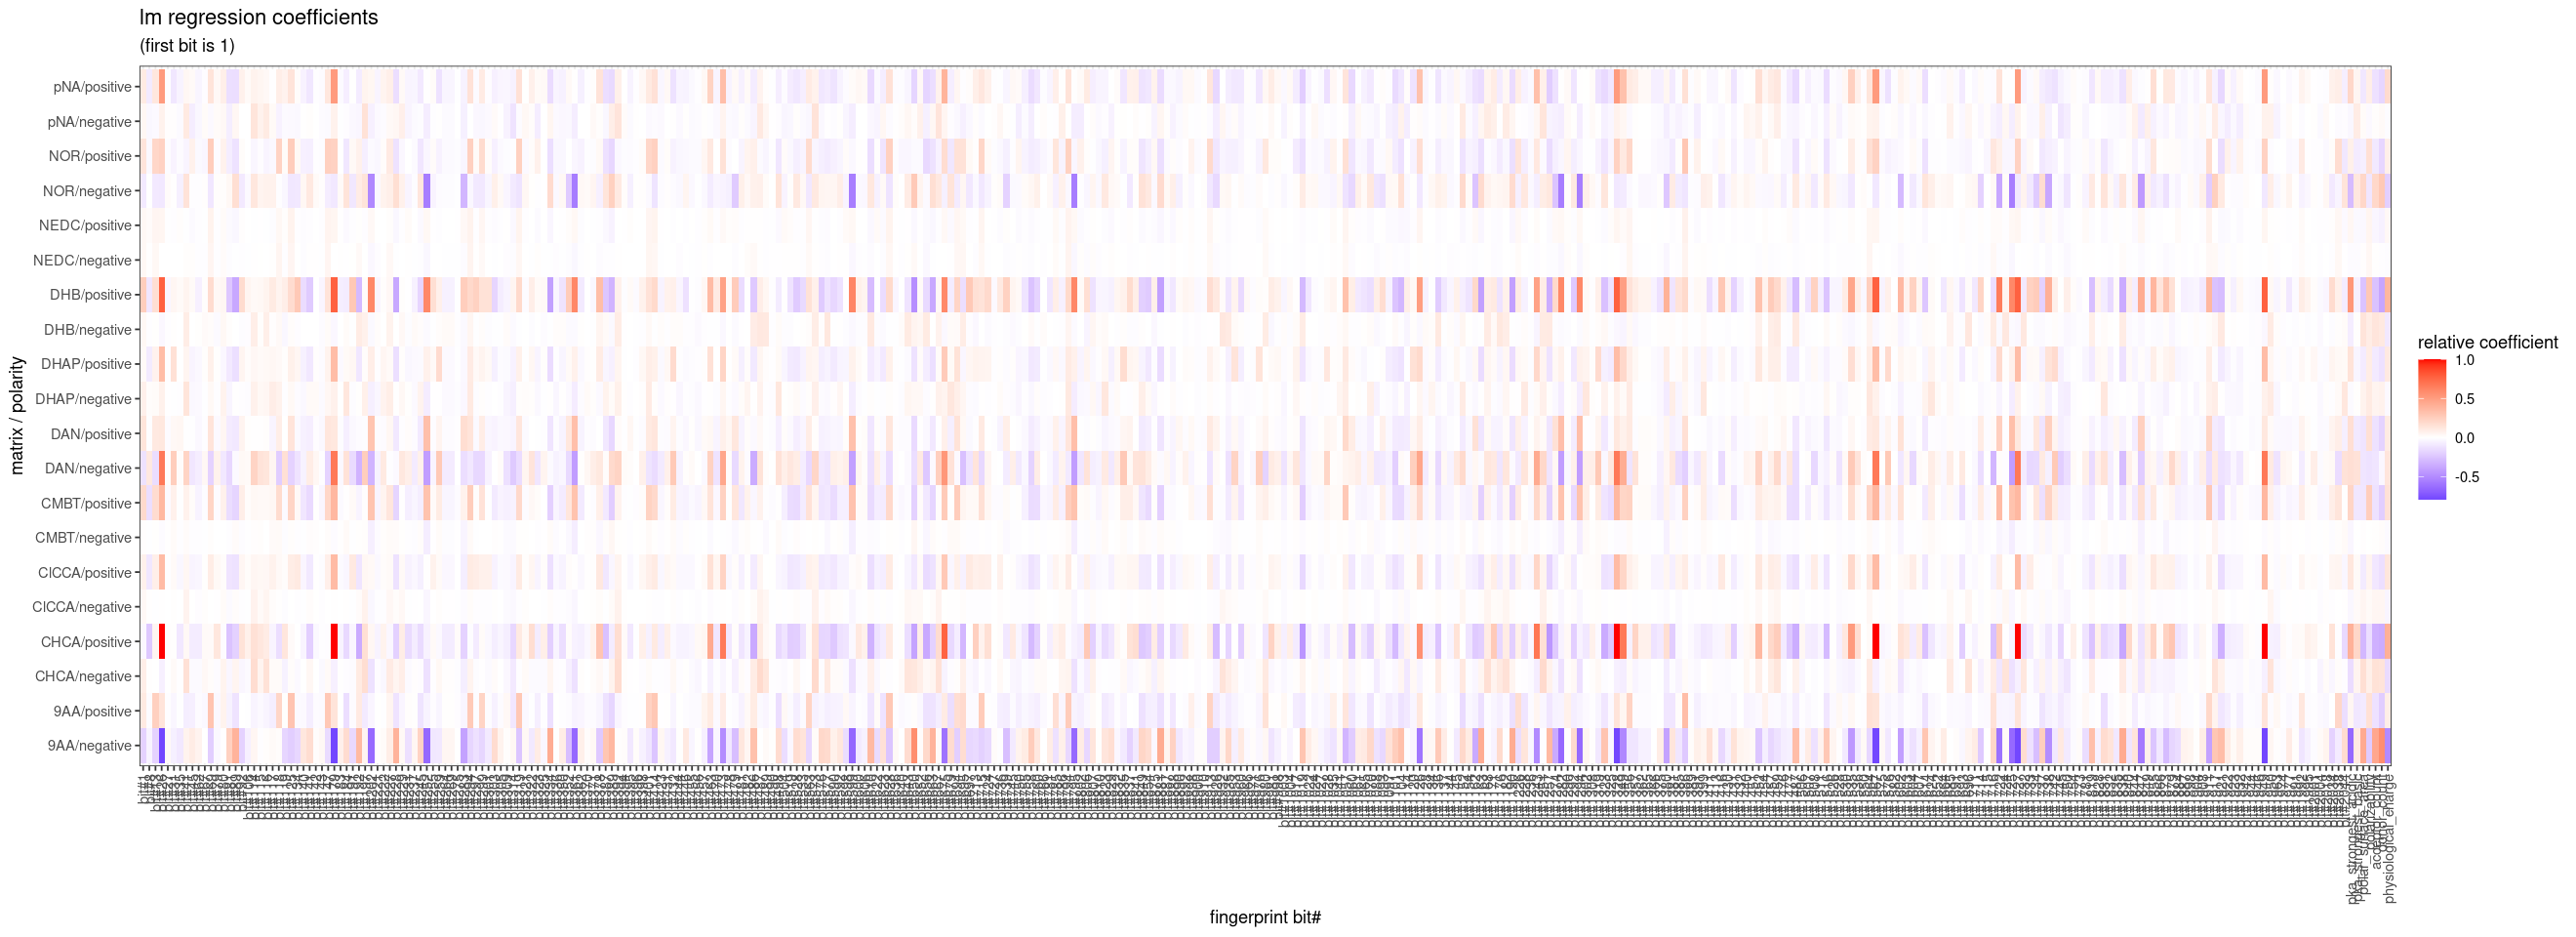

In [43]:
## plot 
options(repr.plot.width=22, repr.plot.height=8)

D <-
bit_coefficients_long %>% #group_by(bit) %>% mutate(max = max(value),
                          #                         min = min(value)) %>%
  #ungroup() %>% filter(max > 0.3 | min < -0.3) %>% 
{
    
    ggplot(data = ., 
           aes(x = as.factor(bit), 
               y = mat_pol, 
               fill = value))+
      geom_tile(show.legend = T)+
      scale_fill_gradient2(low = "blue",mid = "white", midpoint = 0, high = "red", na.value = "gray")+
      labs(fill = "relative coefficient", x = "fingerprint bit#", y = "matrix / polarity", 
           title = "lm regression coefficients", subtitle = '(first bit is 1)')+
      theme_bw()+
      theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
  }

D

In [44]:
## save plot as PNG

save_plot(D, filename = "matrix_predictors_results_no_nl_primary_adducts.pdf", base_height = 5, base_width = 40)